# 8.3 Lab: Decision Trees

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

In [4]:
def regression_report(y_true, y_pred):
    
    error = y_true - y_pred
    percentil = [5,25,50,75,95]
    percentil_value = np.percentile(error, percentil)
    
    metrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('median absolute error', median_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred)),
        ('explained variance score', explained_variance_score(y_true, y_pred))
    ]
    
    print('Metrics for regression:')
    for metric_name, metric_value in metrics:
        print(f'{metric_name:>25s}: {metric_value: >20.3f}')
        
    print('\nPercentiles:')
    for p, pv in zip(percentil, percentil_value):
        print(f'{p: 25d}: {pv:>20.3f}')

## 8.3.1 Fitting Classification Trees

The sklearn library has a lot of useful tools for tress. We first use classification trees to analyze the Carseats data set.

In these data, `Sales` is a continuous variable, and so we begin by recoding it  as a binary variable. We use the `map()` function to create a variable, called `High`, which takes on a value of `Yes` if the `Sales` variable exceeds $8$, and takes on a value of `No` otherwise.

In [5]:
carseats = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Carseats.csv')
carseats['High'] = (carseats.Sales.map(lambda x: 'Y' if x>8 else 'N')).astype("category")


Some preprocessing of the data.

In [6]:
carseats = pd.get_dummies(carseats, columns=["ShelveLoc","Urban","US"], drop_first=True)
print(carseats.describe())

            Sales   CompPrice      Income  Advertising  Population  \
count  400.000000  400.000000  400.000000   400.000000  400.000000   
mean     7.496325  124.975000   68.657500     6.635000  264.840000   
std      2.824115   15.334512   27.986037     6.650364  147.376436   
min      0.000000   77.000000   21.000000     0.000000   10.000000   
25%      5.390000  115.000000   42.750000     0.000000  139.000000   
50%      7.490000  125.000000   69.000000     5.000000  272.000000   
75%      9.320000  135.000000   91.000000    12.000000  398.500000   
max     16.270000  175.000000  120.000000    29.000000  509.000000   

            Price         Age   Education  ShelveLoc_Good  ShelveLoc_Medium  \
count  400.000000  400.000000  400.000000      400.000000        400.000000   
mean   115.795000   53.322500   13.900000        0.212500          0.547500   
std     23.676664   16.200297    2.620528        0.409589          0.498362   
min     24.000000   25.000000   10.000000        0.00

We now  use the `DecisionTreeClassifier()` function to fit a classification tree in order to predict `High` using all variables but `Sales`.

To build a tree, we could use 'gini' or 'entropy' as split criterion at each node. Here we use 'gini' and with a few other hyperparameters.

In [7]:
X_carseat = carseats.drop(["Sales","High"], axis=1)
y_carseat = carseats.High

              precision    recall  f1-score   support

           N       0.81      0.84      0.83       236
           Y       0.76      0.72      0.74       164

    accuracy                           0.79       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.79      0.79      0.79       400



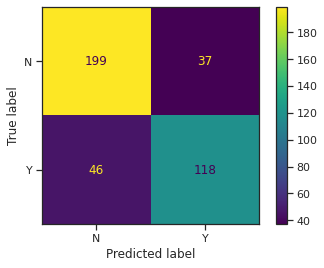

In [8]:
clf_gini = DecisionTreeClassifier(random_state=100, max_depth=3)
clf_gini.fit(X_carseat,y_carseat)

predict_label = clf_gini.predict(X_carseat)
predict_probs = clf_gini.predict_proba(X_carseat)
predict_label = pd.DataFrame(predict_label, columns=["High"], dtype="category", index=carseats.index)
predict_probs = pd.DataFrame(predict_probs, columns=clf_gini.classes_, index=carseats.index)

ConfusionMatrixDisplay.from_predictions(carseats.High, predict_label.High);
print(classification_report(carseats.High, predict_label.High))

One of the most attractive properties of trees is that they can be  graphically displayed. We use the `plot_tree()` function to display the tree structure.

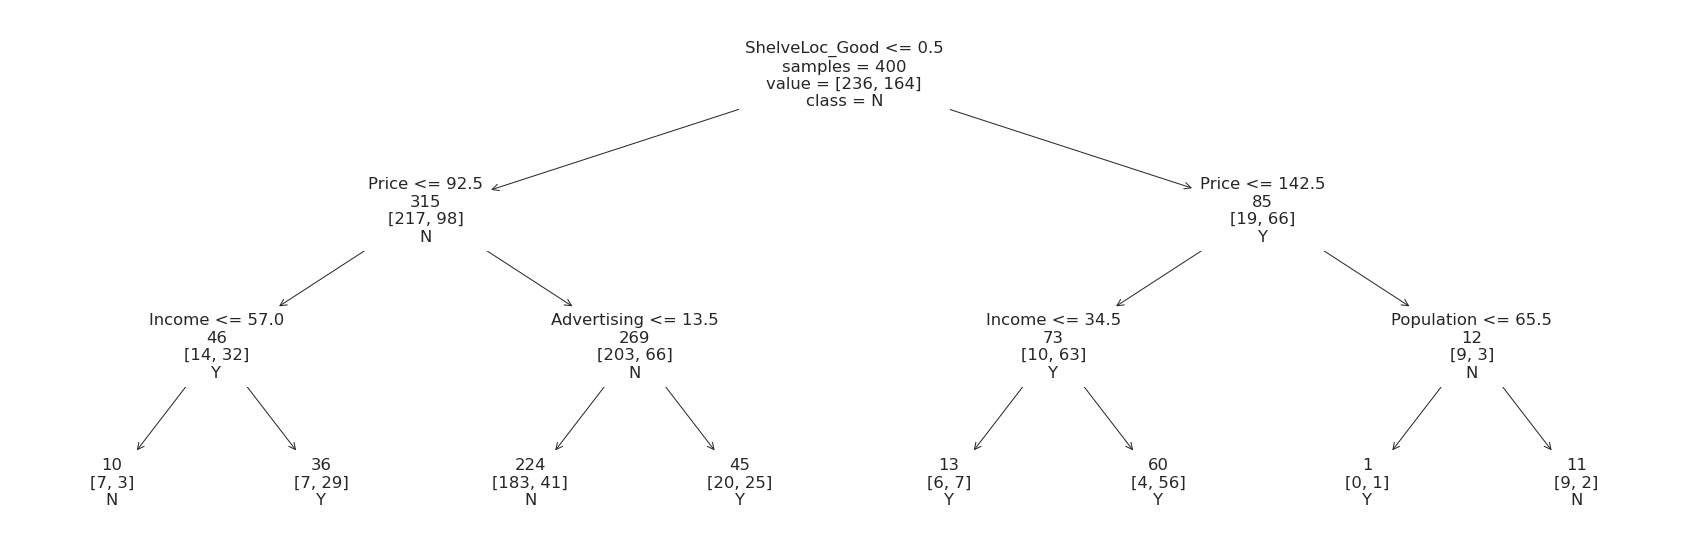

In [9]:
plt.figure(figsize=(30,10))  # customize according to the size of your tree
plot_tree(clf_gini, 
          feature_names=clf_gini.feature_names_in_, 
          class_names=clf_gini.classes_,
          label='root',impurity=False)
plt.show()

The most important indicator of `Sales` appears to be shelving location, since the first branch differentiates `Good` locations from `Bad` and `Medium` locations.


If we just type the `export_text` of the tree object,  `python` prints output corresponding to each branch of the tree. `python` displays the split criterion  (e.g. `Price < 92.5`), the number of observations in  that branch, the deviance, the overall prediction for the branch `High_Y` in (`1` or `0`).

In [10]:
print(export_text(clf_gini, feature_names=list(clf_gini.feature_names_in_)))

|--- ShelveLoc_Good <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- class: N
|   |   |--- Income >  57.00
|   |   |   |--- class: Y
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- class: N
|   |   |--- Advertising >  13.50
|   |   |   |--- class: Y
|--- ShelveLoc_Good >  0.50
|   |--- Price <= 142.50
|   |   |--- Income <= 34.50
|   |   |   |--- class: Y
|   |   |--- Income >  34.50
|   |   |   |--- class: Y
|   |--- Price >  142.50
|   |   |--- Population <= 65.50
|   |   |   |--- class: Y
|   |   |--- Population >  65.50
|   |   |   |--- class: N



In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error. We split the observations into a training set and a test set, build the tree using the training set, and evaluate its performance on the test data. 

The `predict()` function can be used for this purpose. In the case of a classification tree, return the actual class prediction. This approach leads to correct predictions for around $70\,\%$ of the locations in the test data set.

              precision    recall  f1-score   support

           N       0.74      0.78      0.76       118
           Y       0.65      0.60      0.62        82

    accuracy                           0.70       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.70      0.70      0.70       200



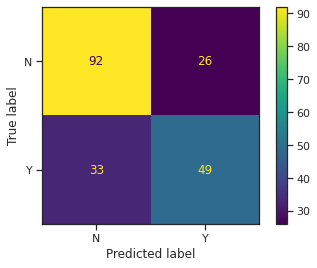

In [37]:
# we first split the dataset into training (200 samples) and test sets.
train_size = 200
X_train, X_test, y_train, y_test = train_test_split(X_carseat, y_carseat, train_size=train_size, random_state=0,)
y_train = y_train.to_frame()
y_test  = y_test.to_frame()

clf_gini = DecisionTreeClassifier(random_state=100)
clf_gini.fit(X_train, y_train)

predict_label = clf_gini.predict(X_test)
predict_probs = clf_gini.predict_proba(X_test)
predict_label = pd.DataFrame(predict_label, columns=["High"], dtype="category", index=X_test.index)
predict_probs = pd.DataFrame(predict_probs, columns=clf_gini.classes_, index=X_test.index)

ConfusionMatrixDisplay.from_predictions(y_test.High, predict_label.High);
print(classification_report(y_test.High, predict_label.High))

(If you re-run the `predict()` function then you might get slightly different results, due to "ties": for instance, this can happen when the training observations corresponding to a terminal node are evenly split between `Yes` and `No` response values.)
Let us build the confusion matrix to evaluate the model in accuracy for both training and test datasets. We can also compute more metrics such as precision, recall, f1-score, etc.

              precision    recall  f1-score   support

           N       1.00      1.00      1.00       118
           Y       1.00      1.00      1.00        82

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



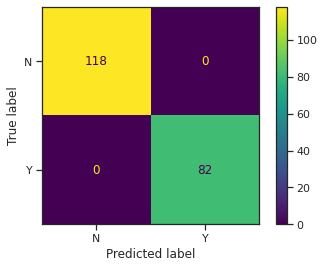

In [12]:
predict_label = pd.DataFrame(clf_gini.predict(X_train), columns=["High"], dtype="category", index=X_train.index)

ConfusionMatrixDisplay.from_predictions(y_train.High, predict_label.High);
print(classification_report(y_train.High, predict_label.High))

The test accuracy of our model is significant lower than our training result, this may indicate overfitting. 
we can go back and change the hyperparameters in the training process to reduce the dimension of the parameter space.


In [12]:
# help(DecisionTreeClassifier)

Next, we consider whether pruning the tree might lead to improved  results.
The function `cost_complexity_pruning_path()` performs cross-validation in order to  determine 
the optimal level of tree complexity; cost complexity pruning is used in order to select a 
sequence of trees for consideration.


In [13]:
path = clf_gini.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.

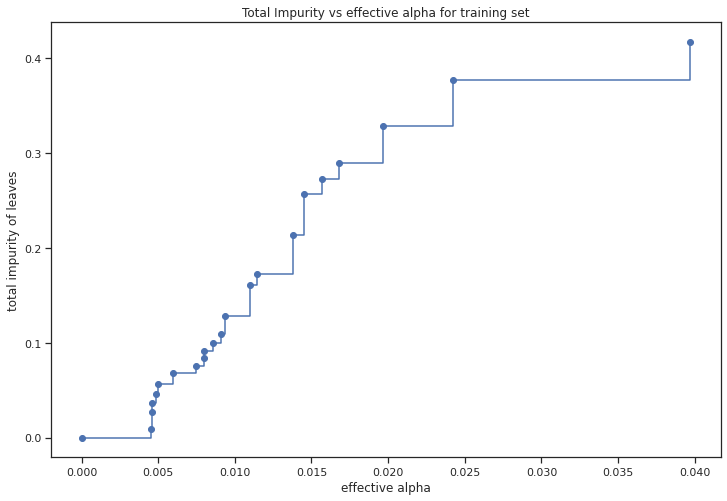

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [15]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=100, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.06661249999999985


For the remainder of this example, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

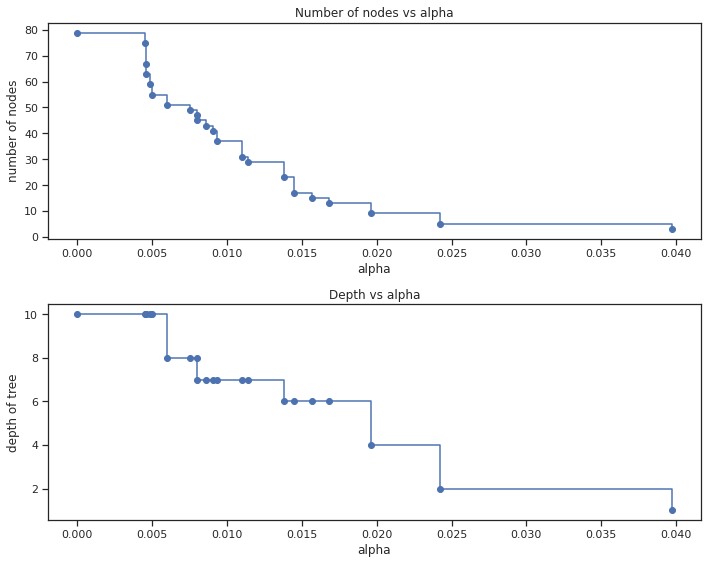

In [16]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, 
the tree overfits, leading to a 100% training accuracy and 73% testing accuracy. As alpha increases, 
more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, 
setting ccp_alpha=0.0048 maximizes the testing accuracy.

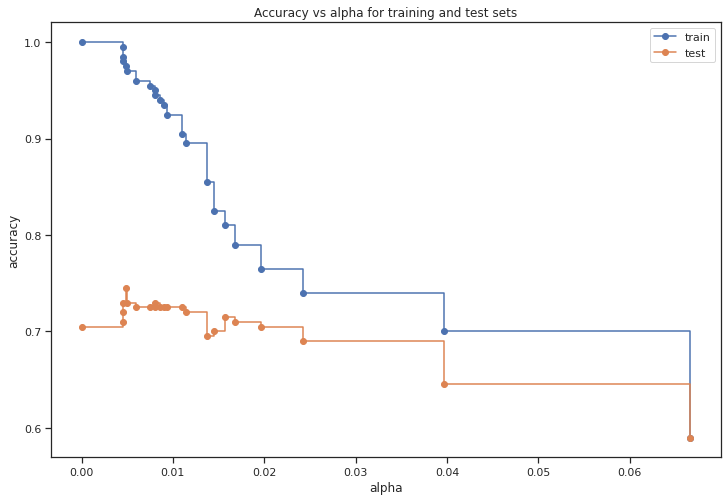

In [16]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and test sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [17]:
[i for i in zip(test_scores, ccp_alphas)]

[(0.705, 0.0),
 (0.71, 0.004500000000000001),
 (0.72, 0.004565217391304347),
 (0.73, 0.004583333333333333),
 (0.745, 0.004838709677419352),
 (0.73, 0.004991134751773053),
 (0.725, 0.006),
 (0.725, 0.0075),
 (0.725, 0.007999999999999998),
 (0.73, 0.008),
 (0.725, 0.008571428571428574),
 (0.725, 0.009072580645161296),
 (0.725, 0.009360717100078804),
 (0.725, 0.011014492753623187),
 (0.72, 0.011428571428571427),
 (0.695, 0.013781609195402299),
 (0.7, 0.014496376811594202),
 (0.715, 0.01570652173913044),
 (0.71, 0.016805555555555546),
 (0.705, 0.019649390243902436),
 (0.69, 0.024206720455228314),
 (0.645, 0.03970452508960576),
 (0.59, 0.06661249999999985)]

We now apply  Minimal Cost-Complexity Pruning with the `ccp_alpha`  parameter in order to prune the tree to obtain the nine-node tree.
How well does this pruned tree perform on the test data set? Once again, we apply the `predict()` function.

              precision    recall  f1-score   support

           N       0.76      0.80      0.78       118
           Y       0.68      0.63      0.66        82

    accuracy                           0.73       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.73      0.73      0.73       200



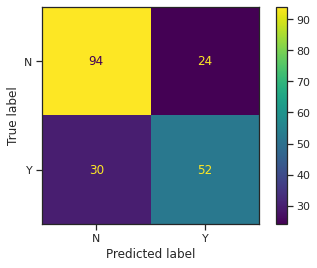

In [18]:
# we first split the dataset into training (200 samples) and test sets.
clf_gini = DecisionTreeClassifier(random_state=100, ccp_alpha=0.0048)
clf_gini.fit(X_train, y_train)

predict_label = clf_gini.predict(X_test)
predict_probs = clf_gini.predict_proba(X_test)
predict_label = pd.DataFrame(predict_label, columns=["High"], dtype="category", index=X_test.index)
predict_probs = pd.DataFrame(predict_probs, columns=clf_gini.classes_, index=X_test.index)

ConfusionMatrixDisplay.from_predictions(y_test.High, predict_label.High);
print(classification_report(y_test.High, predict_label.High))

Now $73\,\%$ of the test observations are correctly classified, so not only has the pruning process produced a more interpretable tree, but it has also slightly improved the classification accuracy.


What we have just done is incorrect, we allowed our testing data to be used for hyper-parameter search.

If we are going to leak the test data we may as well do it properly.

Lets do that properly using a gridsearch with k-fold cross validation.

In [39]:
tuned_parameters = [{"ccp_alpha": ccp_alphas}]

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=100), tuned_parameters, refit=True, cv=10,
)
grid_search.fit(X_carseat, y_carseat)
grid_search.best_params_

{'ccp_alpha': 0.006}

In [48]:
np.mean(grid_search.cv_results_['mean_test_score'])

0.7258695652173914

              precision    recall  f1-score   support

           N       0.74      0.82      0.78       118
           Y       0.70      0.59      0.64        82

    accuracy                           0.73       200
   macro avg       0.72      0.70      0.71       200
weighted avg       0.72      0.72      0.72       200



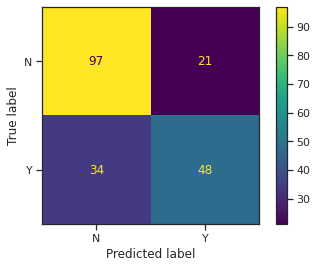

In [40]:
# we first split the dataset into training (200 samples) and test sets.
clf_gini = DecisionTreeClassifier(random_state=100, ccp_alpha=0.006)
clf_gini.fit(X_train, y_train)

predict_label = clf_gini.predict(X_test)
predict_probs = clf_gini.predict_proba(X_test)
predict_label = pd.DataFrame(predict_label, columns=["High"], dtype="category", index=X_test.index)
predict_probs = pd.DataFrame(predict_probs, columns=clf_gini.classes_, index=X_test.index)

ConfusionMatrixDisplay.from_predictions(y_test.High, predict_label.High);
print(classification_report(y_test.High, predict_label.High))

## 8.3.2 Fitting Regression Trees

Here we fit a regression tree to the `Boston`  data set. First, we create a training set, and fit the tree to the training data.

Another attractive feature of a tree is the ability to solve both classification and regression problems.
Here we fit a regression tree to the Boston data set. First, we create a training set, and fit the tree to the training data. 
Let us use the max_depth at 3.

In [20]:
boston = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Boston.csv')

In [21]:
X_boston = boston.drop('medv', axis=1)
y_boston = boston.medv
X_train, X_test, y_train, y_test = train_test_split(X_boston, y_boston, train_size=0.5, random_state=0)
y_train = y_train.to_frame() 
y_test  = y_test.to_frame()

In [23]:
# as we move forward, it is good to keep the hyperparameters together for future iterations.
regr_tree = DecisionTreeRegressor(max_depth=4)
regr_tree.fit(X_train, y_train);

In [24]:
y_pred = pd.DataFrame(regr_tree.predict(X_test), columns=["medv"], index=X_test.index)
regression_report(y_test,y_pred)

Metrics for regression:
      mean absolute error:                3.147
    median absolute error:                2.011
       mean squared error:               23.817
                max error:               29.988
                 r2 score:                0.686
 explained variance score:                0.688

Percentiles:
                        5:               -5.926
                       25:               -1.963
                       50:               -0.156
                       75:                2.188
                       95:                7.775


Notice that the output of `plot_tree()` indicates that only two of the variables have been used in constructing the tree.

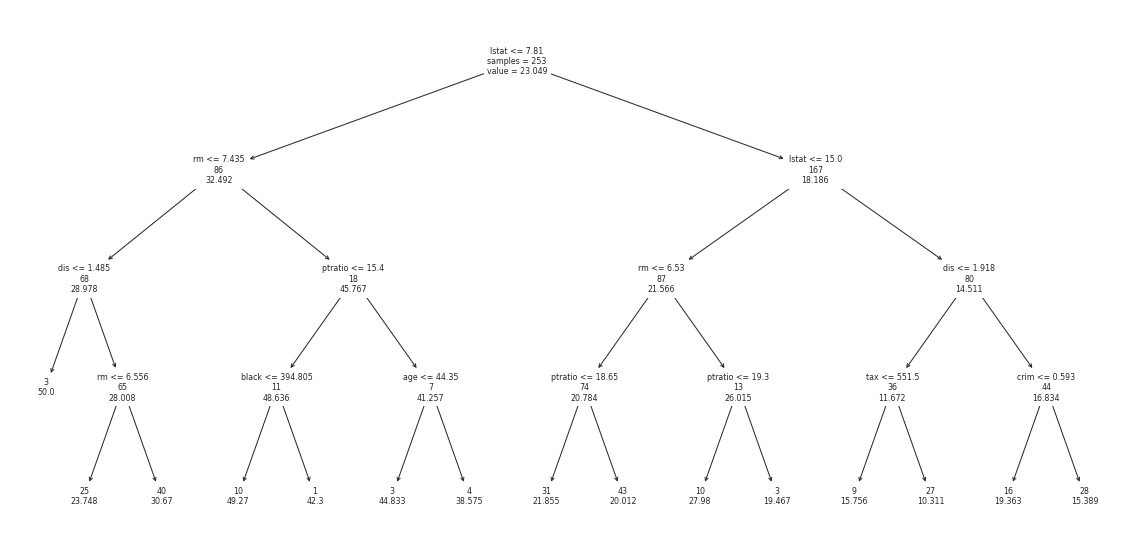

In [25]:
plt.figure(figsize=(20,10))  # customize according to the size of your tree
plot_tree(regr_tree, 
          feature_names=regr_tree.feature_names_in_,           
          label='root',impurity=False)
plt.show()

The variable `lstat` measures the percentage of individuals with {lower  socioeconomic status}, 
while the variable `rm` corresponds to the average number of rooms. The tree indicates that larger 
values of `rm`, or lower values of `lstat`, correspond to more expensive houses. For example, 
the tree predicts a median house price of $\$45{,}767$ for homes in census tracts in which `rm >= 7.435`.

Now you use the `ccp_alpha` with cross validation to see whether pruning the tree will improve performance.

In [26]:
#TODO: Exercise

## 8.3.3 Bagging and Random Forests

Here we apply bagging and random forests (RF) to the Boston data.
RF is an ensemble method, which means it combines the results of multiple decision trees. 
As a result, RF could help to reduce the variance of the model. 
Similar to decision trees, RF can be used to solve both classification and regression problems.


In this excercise, we will use the randomForest package in Python. 
The exact results obtained in this section may depend on the version of Python and the version of 
the randomForest package installed on your computer. 

In [26]:
all_features = X_train.shape[1] #13
all_features

13

In [27]:
# we reused the previous train and test sets.
regr_bagging = RandomForestRegressor(max_features=all_features, random_state=1)
regr_bagging.fit(X_train, y_train);

The argument `max_features = 13` indicates that all $13$ predictors should be considered for each split of the tree---in other words, that bagging should be done.
How well does this bagged model perform on the test set?

In [28]:
y_pred = pd.DataFrame(regr_bagging.predict(X_test), columns=["medv"], index=X_test.index)
regression_report(y_test,y_pred)

Metrics for regression:
      mean absolute error:                2.433
    median absolute error:                1.511
       mean squared error:               16.175
                max error:               25.885
                 r2 score:                0.787
 explained variance score:                0.787

Percentiles:
                        5:               -4.588
                       25:               -1.637
                       50:               -0.273
                       75:                1.309
                       95:                6.122


We can compare the test accuracy of the bagging model with the test accuracy of the singl regression tree above.
Normally, the bagging model is better than the single tree model.

The test set MSE associated with the bagged regression tree is $16.17$, about two-thirds of that obtained using an optimally-pruned single tree.

We can grow a random forest in exactly the same way, except that we'll use a smaller value of the max_features argument. 
Theoretically, radomly selecting a subset of features could reduce the correlation of the trees and can reduce the variance of the model.

In [29]:
# here we'll use max_features = 3 (close to square root of all features as a rule of thumb)
regr_rf = RandomForestRegressor(max_features=3, random_state=1)
regr_rf.fit(X_train, y_train);

In [30]:
y_pred = pd.DataFrame(regr_rf.predict(X_test), columns=["medv"], index=X_test.index)
regression_report(y_test,y_pred)

Metrics for regression:
      mean absolute error:                2.395
    median absolute error:                1.643
       mean squared error:               15.386
                max error:               29.826
                 r2 score:                0.797
 explained variance score:                0.797

Percentiles:
                        5:               -4.203
                       25:               -1.780
                       50:               -0.435
                       75:                1.357
                       95:                5.903


The test set MSE is even lower; this indicates that random forests yielded an improvement over bagging in this case.
By default, `RandomForestClassifier()` uses $p/3$ variables when building a random forest of regression trees, and $\sqrt{p}$ variables when building a random forest of classification trees.
The test set MSE is $15.38$; this indicates that random forests yielded an improvement over bagging in this case.

Using the `importance()` function, we can view the importance of each variable.
Two measures of variable importance are reported. The first is based upon the mean decrease of accuracy in predictions on the out of bag samples when a given variable is permuted. The second is a measure of the total decrease in node impurity that results from splits over that variable, averaged over all trees (this was plotted in Figure 8.9). In the case of regression trees, the node impurity is measured by the training RSS, and for classification trees by the deviance. Plots of these importance measures can be produced using the `feature_importances_` attribute.

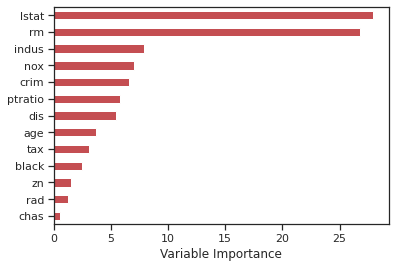

In [31]:
# RF provides multiple ways to interpret the model. One way is to see the importance of each feature.
Importance = pd.DataFrame({'Importance':regr_rf.feature_importances_*100}, index=X_train.columns)
Importance.sort_values(by='Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all of the trees considered in the random forest, the wealth of the community (`lstat`) and the house size (`rm`) are by far the two most important variables.

## 8.3.4 Boosting

Here we use the GradientBoostingRegressor package. The argument n_estimators=500 indicates that we want 500 trees, 
and the option max_depth=4 limits the depth of each tree. See the manuel for more details.

In [32]:
regr_boost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.02, random_state=1)
regr_boost.fit(X_train, y_train);

We see that `lstat` and `rm` are by far the most important variables. We can also produce *partial dependence plots* for these two variables. These plots illustrate the marginal effect of the selected variables on the response after *integrating* out the other variables. In this case, as we might expect, median house prices are increasing with `rm` and decreasing with `lstat`.

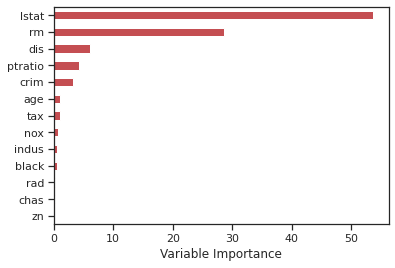

In [33]:
# let us check the feature importance and MSE.
feature_importance = regr_boost.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X_train.columns).sort_values(inplace=False)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

We now use the boosted model to predict `medv` on the test set:

In [34]:
y_pred = pd.DataFrame(regr_boost.predict(X_test), columns=["medv"], index=X_test.index)
regression_report(y_test,y_pred)

Metrics for regression:
      mean absolute error:                2.404
    median absolute error:                1.449
       mean squared error:               15.073
                max error:               24.288
                 r2 score:                0.801
 explained variance score:                0.801

Percentiles:
                        5:               -4.711
                       25:               -1.583
                       50:               -0.182
                       75:                1.213
                       95:                6.611


The test MSE obtained is $15.07$: this is superior to the test MSE of random forests and bagging. If we want to, we can perform boosting with a different value of the shrinkage parameter $\lambda$ in (8.10). The default value is $0.1$, but this is easily modified.

In this case, using $\lambda=0.2$ leads to a lower test MSE than $\lambda=0.1$.

## 8.3.5 Bayesian Additive Regression Trees

https://www.pymc.io/projects/examples/en/latest/case_studies/BART_introduction.html

Here we discuss Bayesian additive regression trees (BART), another ensemble method that uses decision trees as its building blocks.
BART is related to both Random forest and boosting: each tree is constructed in a random manner as in bagging and random forests, 
and each tree tries to capture signal not yet accounted for by the current model, as in boosting. 
The main novelty in BART is the way in which new trees are generated.

In [36]:
# End of Chapter 8